#  Анализ развлекательного приложения Procrastinate Pro+

Проект выполнен для маркетингового анализа развлекательного приложения Procrastinate Pro+. При огромных вложениях в рекламу, последние несколько месяцев компания терпит убытки.

Цель: разобраться в причинах убытков и помочь компании выйти в плюс.

Входные данные: данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года(лог сервера с данными об их посещениях,выгрузка их покупок за этот период, рекламные расходы).

План работы:
1. Рассмотреть данные, их предобработка
2. Определение функций для расчёта и анализа LTV, ROI, удержания и конверсии.
3. Провести исследовательский анализ
4. Рассмотреть маркетинговые показатели
5. Оценить окупаемость рекламы
6. Сделать вывод


## Этап 1. Обзор данных, предобработка

In [ ]:
import pandas as pd
from datetime import datetime, timedelta, date
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
expenses = pd.read_csv('costs_info_short.csv')

Проведем предобработку данных о визитах.

In [ ]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Приведем названия столбцов к верному виду:

In [ ]:
visits = visits.rename(columns={'User Id': 'user_id', 
                                'Region': 'region', 
                                'Device': 'device', 
                                'Channel': 'channel', 
                                'Session Start': 'session_start', 
                                'Session End': 'session_end'})

In [ ]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Есть столбцы, тип которых должен быть временным. Исправим:

In [ ]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [ ]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [ ]:
visits.duplicated().sum()

0

Проведем предобработку данных о заказах. Аналогично проверим наименования столбцов, типы данных, пропуски и дубликаты.

In [ ]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [ ]:
orders = orders.rename(columns={'User Id': 'user_id', 
                                'Event Dt': 'event_dt', 
                                'Revenue': 'revenue'})

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [ ]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [ ]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [ ]:
orders.duplicated().sum()

0

Проведем предобработку данных о расходах. Аналогично проверим наименования столбцов, типы данных, пропуски и дубликаты.

In [ ]:
expenses.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [ ]:
expenses = expenses.rename(columns={'Channel': 'channel'})

In [ ]:
expenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [ ]:
expenses['dt'] = pd.to_datetime(expenses['dt']).dt.date

In [ ]:
expenses.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

In [ ]:
expenses.duplicated().sum()

0

В данных нет пропусков и дубликатов.

## Этап 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [ ]:
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

In [ ]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # добавляем данные о выручке в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # вычисляем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',
            aggfunc='sum',
        )
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time


In [ ]:
def get_ltv_roi(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [ ]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Этап 3. Исследовательский анализ данных

В данном этапе рассмотрены:
- Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.
- Выводы, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построение таблицы, отражающей количество пользователей и долю платящих из каждой страны.
- Выводы, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построение таблицы, отражающей количество пользователей и долю платящих для каждого устройства.
- Изучение рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построение таблицы, отражающей количество пользователей и долю платящих для каждого канала привлечения.

1. С помощью функции get_profiles составим профили пользователей и сохраним в переменной profiles. 

In [ ]:
profiles = get_profiles(visits, orders, expenses)

In [ ]:
profiles.agg({'dt': ['min', 'max']})

,dt
min,2019-05-01
max,2019-10-27


Первая дата привлечения пользователей - 1 мая 2019 года.
Последняя дата привлечения пользователей - 27 октября 2019 года. Это совпадает с описанием входных данных, так как там данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года

2. Сгруппируем профили пользователей по стране и определим долю платящих.

In [ ]:
(
    profiles.groupby('region')
    .agg({'user_id': 'nunique',
          'payer': 'mean'})
    .sort_values(by = 'payer', ascending = False)
)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


На США приходится наибольшая доля платящих пользователей. 

3. Сгруппируем профили пользователей по устройствам, которыми они пользуются и определим, какие устройства предпочитают платящие пользователи.

In [ ]:
(
    profiles.groupby('device')
    .agg({'user_id': 'nunique',
          'payer': 'mean'})
    .sort_values(by = 'payer', ascending = False)
)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Больше всего платящие пользователи используют Mac и iPhone, их доли примерно равны.

4. Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 

In [ ]:
(
    profiles.groupby('channel')
    .agg({'user_id': 'nunique',
          'payer': 'mean'})
    .sort_values(by = 'payer', ascending = False)
)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


Таким образом, больше всего пользователей пришло из FaceBoom.

## Этап 4. Маркетинг


1. Рассчитаем общую сумму расходов на маркетинг. Это показатель ltv, поэтому поспользуемся подходящей функцией.

In [ ]:
observation_date = profiles['dt'].max() # момент анализа
observation_date = datetime(2019, 11, 1).date()

analysis_horizon = 7  # горизонт анализа

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon
)

ltv = ltv.drop(columns=['cohort_size'])
ltv['sum'] = ltv.sum(axis = 1)
ltv

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,sum
cohort,,,,,,,,
All users,0.242887,0.312709,0.366375,0.41092,0.450145,0.484192,0.515098,2.782325


По таблице видно распределение расходов на маркетинг по дням.

2. Рассмотрим теперь, как распределены траты по рекламным источникам.

In [ ]:
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel']
)
ltv = ltv.drop(columns=['cohort_size'])
ltv['sum'] = ltv.sum(axis = 1)
ltv.sort_values(by = 'sum', ascending = False)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,sum
channel,,,,,,,,
lambdaMediaAds,0.448962,0.629911,0.758761,0.881108,1.014690,1.131831,1.232568,6.097831
TipTop,0.345795,0.501300,0.626846,0.743130,0.845822,0.937960,1.014913,5.015767
FaceBoom,0.585065,0.661399,0.700755,0.728901,0.747391,0.760152,0.774327,4.957991
AdNonSense,0.508309,0.593194,0.649001,0.687938,0.710260,0.736484,0.757248,4.642434
RocketSuperAds,0.208996,0.317120,0.398534,0.458464,0.520431,0.576064,0.643932,3.123540
WahooNetBanner,0.192192,0.291127,0.378523,0.443210,0.516954,0.568232,0.628250,3.018488
YRabbit,0.165134,0.214709,0.256799,0.305206,0.355504,0.387071,0.412793,2.097216
MediaTornado,0.138807,0.190744,0.249574,0.295554,0.339473,0.373944,0.395775,1.983871
LeapBob,0.112098,0.162619,0.210786,0.239806,0.264712,0.294084,0.319577,1.603682


Наибольшие траты у источника lambdaMediaAds, наименьшие - lambdaMediaAds, TipTop, FaceBoom.

3. Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

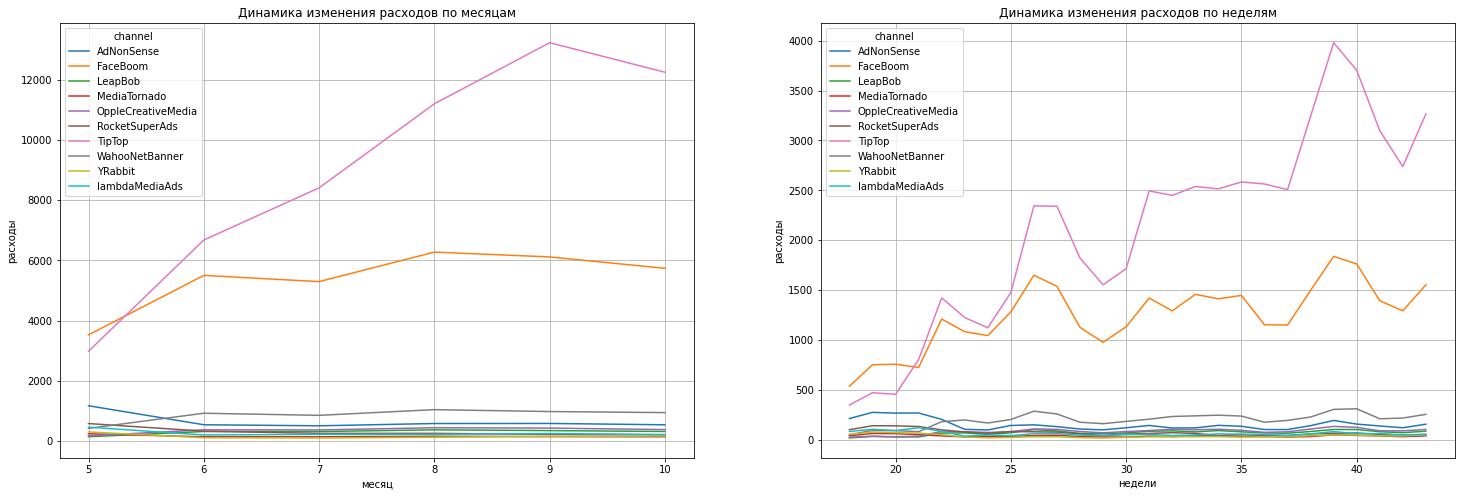

In [ ]:
expenses['dt'] = pd.to_datetime(expenses['dt'])
expenses['month'] = expenses['dt'].dt.month
expenses['week'] = expenses['dt'].dt.isocalendar().week

plt.figure(figsize=(25, 8))

expenses.pivot_table(index = 'month', columns = 'channel', values = 'costs',aggfunc = 'sum').plot(grid = True, ax=plt.subplot(1, 2, 1))
plt.title('Динамика изменения расходов по месяцам')
plt.ylabel('расходы')
plt.xlabel('месяц')

expenses.pivot_table(index = 'week', columns = 'channel', values = 'costs',aggfunc = 'sum').plot(grid = True, ax=plt.subplot(1, 2, 2))
plt.title('Динамика изменения расходов по неделям')
plt.ylabel('расходы')
plt.xlabel('недели')

plt.show()

Выделяются два канала - TipTop, FaceBoom, у них наибольшие траты. График по месяцам более сглажен.

4. Рассмотрим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [ ]:
(profiles
 .groupby('channel')
 .agg(users = ('user_id', 'nunique'),
      payers = ('payer', 'sum'), 
      payers_share = ('payer', 'mean'),
      mean_CAC = ('acquisition_cost', 'mean'))
 .sort_values(by = 'mean_CAC', ascending = False)
 .reset_index()
 .style.format({'payers': '{:.0f}', 'payers_share': '{:.2%}', 'mean_CAC': '{:.2f}'})
)

,channel,users,payers,payers_share,mean_CAC
0,TipTop,19561,1878,9.60%,2.80
1,FaceBoom,29144,3557,12.20%,1.11
2,AdNonSense,3880,440,11.34%,1.01
3,lambdaMediaAds,2149,225,10.47%,0.72
4,WahooNetBanner,8553,453,5.30%,0.60
5,RocketSuperAds,4448,352,7.91%,0.41
6,OppleCreativeMedia,8605,233,2.71%,0.25
7,YRabbit,4312,165,3.83%,0.22
8,MediaTornado,4364,156,3.57%,0.22
9,LeapBob,8553,262,3.06%,0.21


Наибольшее у канала TipTop - 2.8.

## Этап 5. Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализирована окупаемость рекламы. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определена самостоятельно.

В данном этапе рассмотрены:
- Анализ окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверка конверсии, удержания пользователей и динамика её изменения. Графики конверсии и удержания.
- Анализ окупаемости рекламы с разбивкой по устройствам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Анализ окупаемости рекламы с разбивкой по странам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Анализ окупаемости рекламы с разбивкой по рекламным каналам. Графики  LTV и ROI, а также графики динамики LTV, CAC и ROI.


In [ ]:
observation_date = date(2019, 11, 1)

analysis_horizon = 14

#Уберем органических пользователей
profiles = profiles[profiles['channel'] != 'organic'] 

1.  Рассмотрим окупаемость рекламы c помощью графиков.

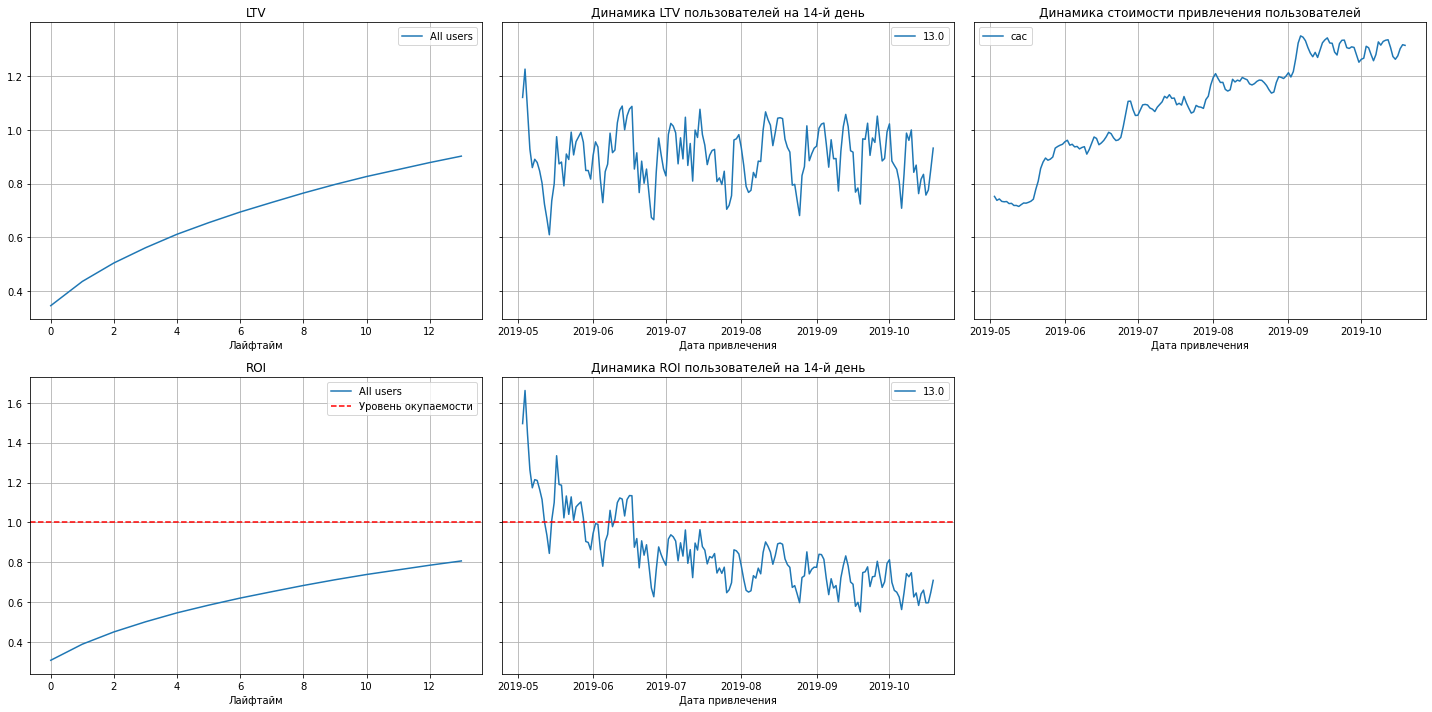

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
     profiles, orders, observation_date, analysis_horizon
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=3) 

- Реклама не окупается
- CAC не стабилен
- Есть влияние сезонного фактора, так как к осени LTV понижается

2. Проверим конверсию пользователей и динамику её изменения.

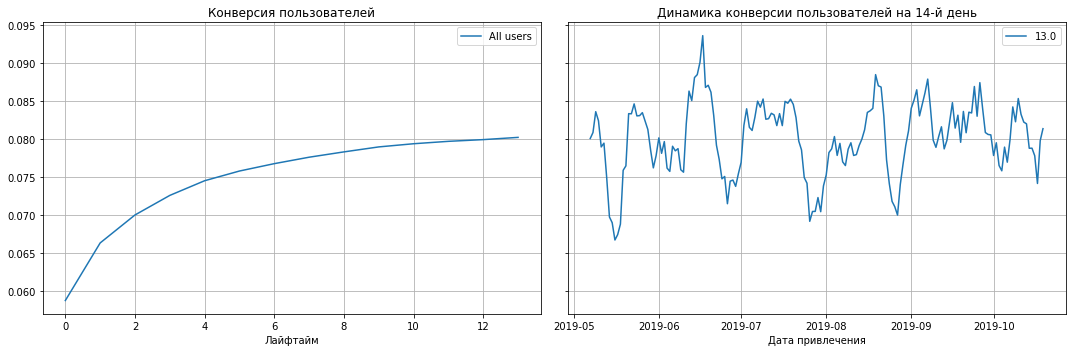

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon
)

plot_conversion(conversion, conversion_history, analysis_horizon) 

Судя по графику, пользователи хорошо и постоянно конвертируются.

Проверим удержание пользователей и динамику изменения.

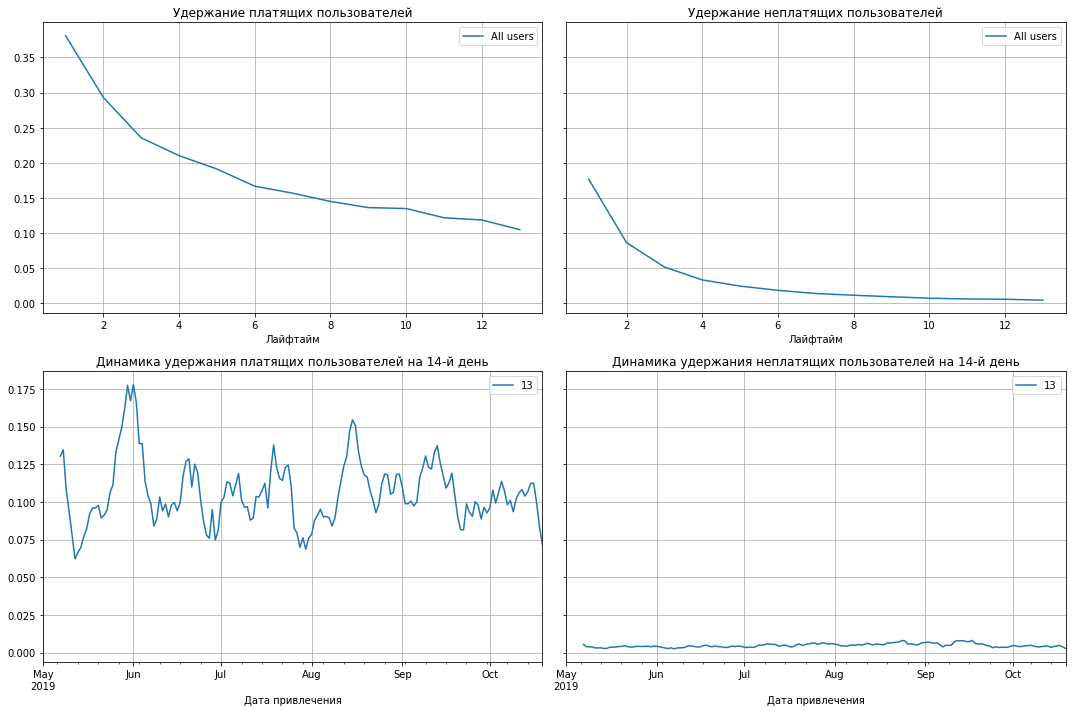

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon
)

plot_retention(retention, retention_history, analysis_horizon) 

Платящие и неплатящие пользователи плохо удерживаются. Для неплатящих пользователей удержание 14-го дня ниже, чем у платящих. Это верно, так как платящие пользователи могут оставаться подольше.



3.  Проверим окупаемость рекламы с разбивкой по устройствам.

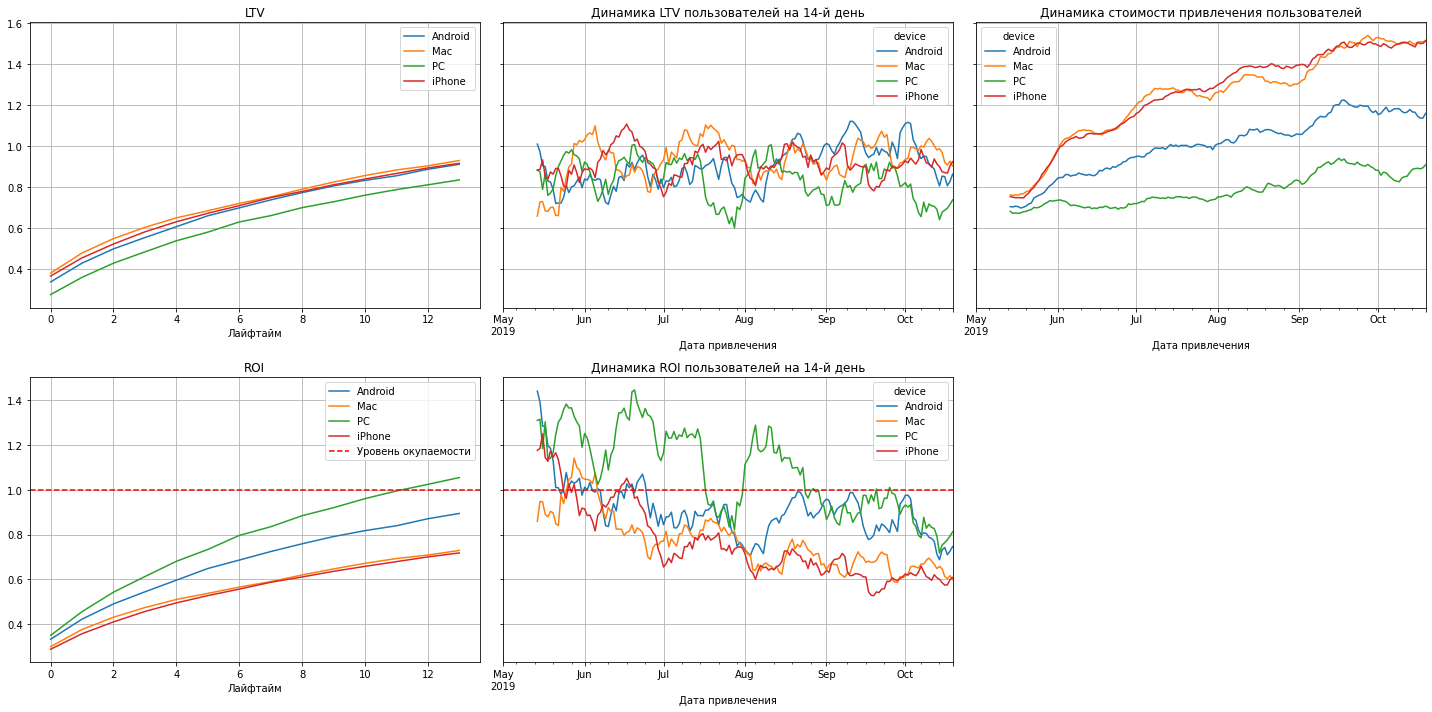

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi, roi_history = get_ltv_roi(
    profiles, orders, observation_date, analysis_horizon, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi, roi_history, analysis_horizon, window=14
) 

Пользователи всех устройств не окупаются, кроме пользователей PC.


4. Проверим окупаемость рекламы с разбивкой по странам.

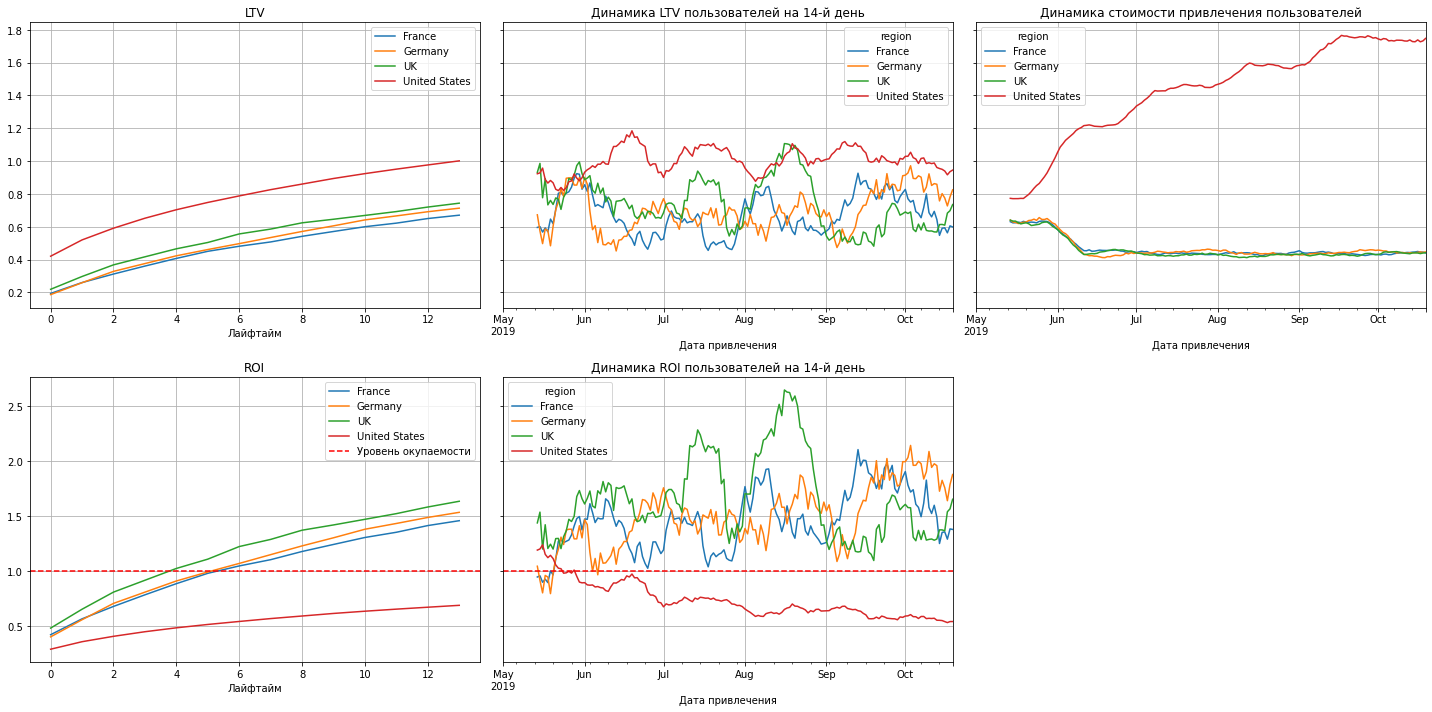

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi, roi_history = get_ltv_roi(
    profiles, orders, observation_date, analysis_horizon, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi, roi_history, analysis_horizon, window=14
) 

С разбивкой по странам показателии средние. Все страны окупаются, кроме США. Однако, в США наибольшее количество платящих пользователей.

5. Проверим окупаемость рекламы с разбивкой по рекламным каналам.

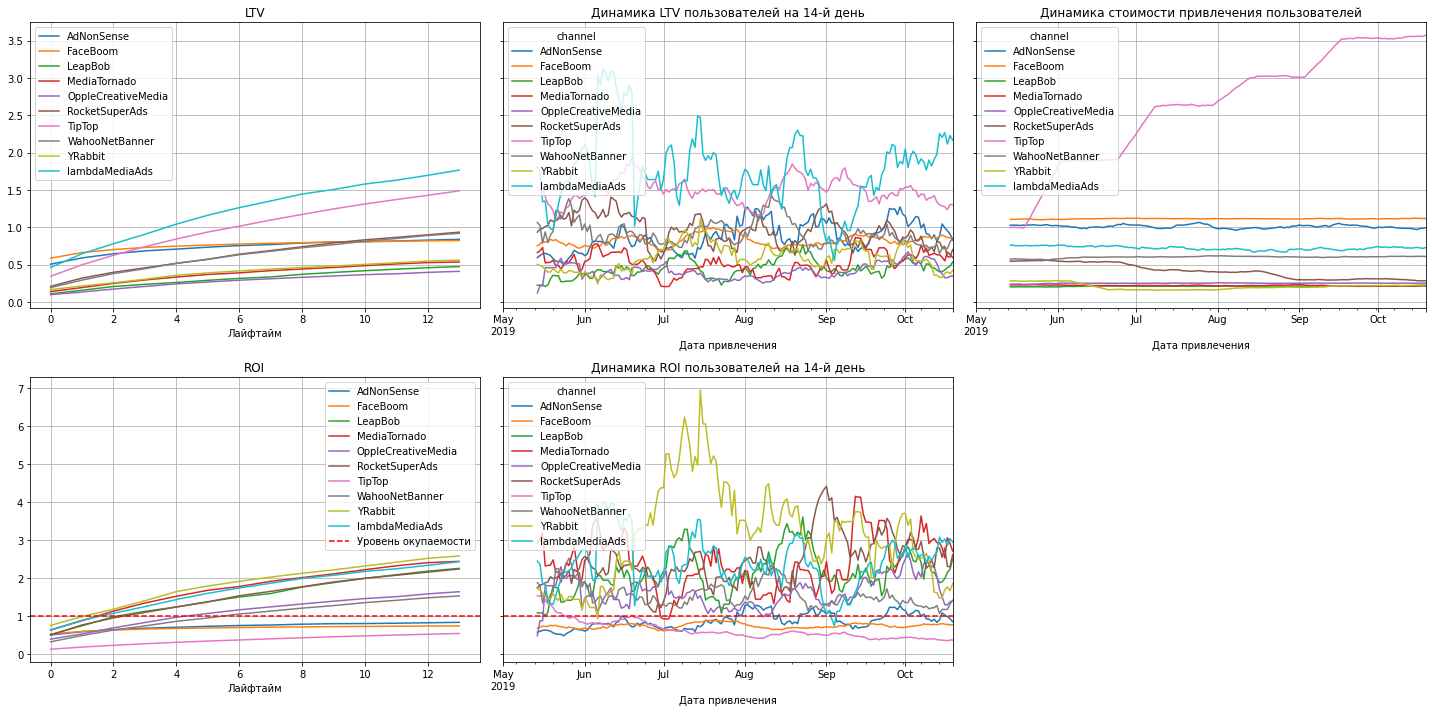

In [ ]:
ltv_raw, ltv_grouped, ltv_history, roi, roi_history = get_ltv_roi(
    profiles, orders, observation_date, analysis_horizon, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi, roi_history, analysis_horizon, window=14
) 

Из худших показателей можно выделить канал TipTop, AdNonSense, Faceboom. Эти рекламные каналы не окупаются.

- реклама, направленная на привлечение пользователей, не окупается
- на окупаемость рекламы негативно влияют мобильные устройства, пользователи из США и 3 канала рекламы
- проблема неокупаемость в том, что пользователи не удерживаются

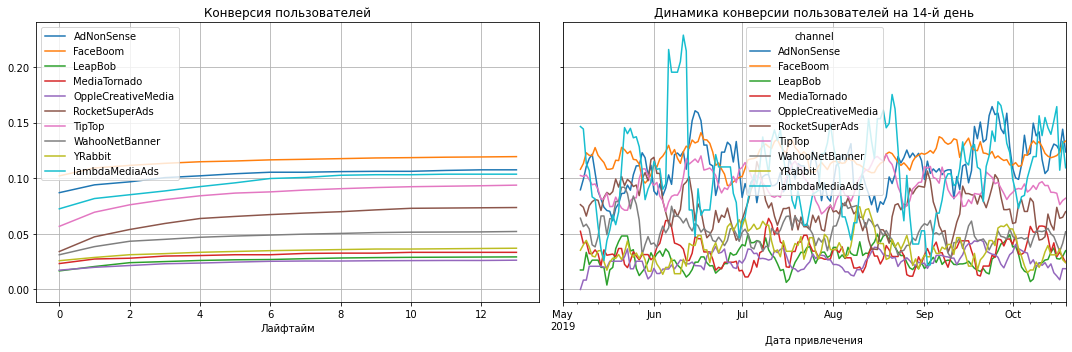

In [ ]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions = ['channel']
)

plot_conversion(conversion, conversion_history, analysis_horizon) 

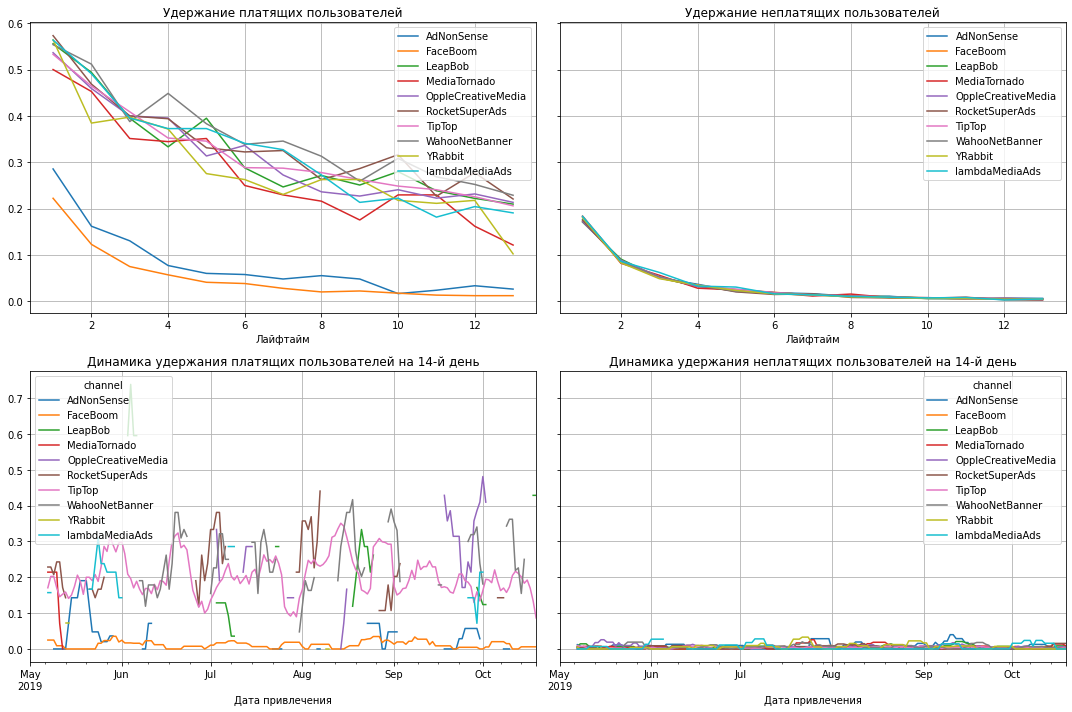

In [ ]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon, dimensions = ['channel']
)

plot_retention(retention, retention_history, analysis_horizon) 

Каналы AdNonSense, Faceboom лучше остальных конвертируют пользователей, но у этих каналов самое низкое удержание. Таким образом, эти каналы приводят пользователей с низким качеством.

## Вывод

Перед исследованием были получены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы. 
В данных были ошибки. После их предобработки все было устранено. 

В ходе анализа было составлены профили пользователей, выявлено, что пользователи преимущественно из США. Пользователи используют все устройства примерно одинаково, но лидирует Mac. Были рассмотрены траты по рекламным источникам. Наибольшие расходы направлены на TipTop и FaceBoom. Также проанализирована средняя стоимость привлечение одного пользователя (CAC) из каждого источника. TipTop занял лидирующую позицию.

Расходы на рекламу не окупаются. При разбивке показателей по странам, устройствам и каналам рекламы, видно, что CAC везде не стабилен. 

При рассмотрении показателей по странам можно выделить США. Пользователи из этой страны не окупаются, также CAC страны стремительно растет относительно других стран.

Пользователи почти всех устройств не окупаются, кроме пользователей PC. Возможно, приложение плохо адаптировано под мобильные и Mac устройства. Худшие показатели у пользователей Mac и IPhone. Стоит передать задачу тестировщикам проверить реализацию на этих устройствах. Особенно для Mac, так как основная масса пользователей США использует технику apple.

Хуже всего окупаются каналы рекламы TipTop, AdNonSense, Faceboom. На эти каналы приходятся большие расходы, но окупаемость самая низкая из всех. Также у этих каналов самый высокий CAC. Каналы AdNonSense, Faceboom приводят пользователей с низким качеством. 

Лучшая окупаемость заметна у канала YRabbit. У этого канала низкий и почти стабильный CAC относительно других каналов.

Пользователи хорошо и постоянно конвертируются, но умеренно удерживаются. В этом и есть проблема окупаемости. 

За 14 дней Retention Rate значительно снижается. В таком случае отделу маркетинга следует:
- собирать обратную связь от уходящих пользователей, чтобы найти причины
- информировать клиентов о скидках, бонусах и программах лояльности, поддерживать их вовлеченность
- составлять персонализированные предложения: UX-стратегии, e-mail рассылки, персональные рекомендации, push-уведомления
- уделить особое внимание пользователям США, составить персонализированные предложения, предварительно наладив работу на apple устройствах
- сократить рекламу по каналу TipTop, AdNonSense, Faceboom
- переключить внимание на канал YRabbit
- настроить таргетированное привлечение для канала FaceBoom, так как у него лучшая конверсия. При подборе правильных характеристик и увелечении Retentaion Rate можно достигнуть хороший результат окупаемости